# Differential expression analysis


You have run the nf-core/rnaseq pipeline and checked the first quality control metrics of your fastq files. This was, however, only the primary analysis and we want to take it further.

Due to the computational demand of the pipeline, you only ran the pipeline on two of the 16 samples in the study yesterday. We provide you an essential output of nf-core/rnaseq pipeline in the `data` folder: It contains the combined epression matrix as produced by Salmon, which provides transcript levels for each gene (rows) and each sample (columns).


We would now like to understand exactly the difference between the expression in our groups of mice. 
Which pipeline would you use for this?

We could use the nf-core/differentialabundance pipeline. This one computes DEGs and GSEA.  

1. Optionally generate a list of genomic feature annotations using the input GTF file (if a table is not explicitly supplied).
2. Cross-check matrices, sample annotations, feature set and contrasts to ensure consistency.
3. Run differential analysis over all contrasts specified.
4. Optionally run a differential gene set analysis.
5. Generate exploratory and differential analysis plots for interpretation.
6. Optionally build and (if specified) deploy a Shiny app for fully interactive mining of results.
7. Build an HTML report based on R markdown, with interactive plots (where possible) and tables.


Have a close look at the pipeline's "Usage" page on the [nf-core docs](nf-co.re). You will need to create a samplesheet (based on the column names in the provided matrix).

In [27]:
import pandas as pd

# Read gene counts
df = pd.read_csv("/home/chrissi/BioPrak/computational-workflows-2025/notebooks/day_03/data/salmon.merged.gene_counts.tsv", sep="\t")
print(df.head())

              gene_id gene_name  Sham_oxy_1  Sham_oxy_2  Sham_oxy_3  \
0  ENSMUSG00000000001     Gnai3        69.0       294.0       259.0   
1  ENSMUSG00000000003      Pbsn         0.0         0.0         0.0   
2  ENSMUSG00000000028     Cdc45         1.0        10.0         2.0   
3  ENSMUSG00000000031       H19         0.0         0.0         0.0   
4  ENSMUSG00000000037     Scml2        12.0        21.0        12.0   

   Sham_oxy_4  Sham_Sal_1  Sham_Sal_2  Sham_Sal_3  Sham_Sal_4  SNI_oxy_1  \
0       444.0       242.0       651.0       622.0       406.0      383.0   
1         0.0         0.0         0.0         0.0         0.0        0.0   
2         6.0        15.0        15.0        22.0        12.0        9.0   
3         0.0         0.0         1.0         0.0         0.0        0.0   
4        18.0         9.0        24.0        36.0        19.0       18.0   

   SNI_oxy_2  SNI_oxy_3  SNI_oxy_4  SNI_Sal_1  SNI_Sal_2  SNI_Sal_3  SNI_Sal_4  
0      518.0      349.0      281.0 

In [28]:
# Creates variables for samplesheet
col_list = df.columns.tolist()
print(col_list)

condition = [col.rsplit("_", 1)[0] for col in df.columns]
print(condition)

replicate = [col.rsplit("_", 1)[1] for col in df.columns]
print(replicate)    


['gene_id', 'gene_name', 'Sham_oxy_1', 'Sham_oxy_2', 'Sham_oxy_3', 'Sham_oxy_4', 'Sham_Sal_1', 'Sham_Sal_2', 'Sham_Sal_3', 'Sham_Sal_4', 'SNI_oxy_1', 'SNI_oxy_2', 'SNI_oxy_3', 'SNI_oxy_4', 'SNI_Sal_1', 'SNI_Sal_2', 'SNI_Sal_3', 'SNI_Sal_4']
['gene', 'gene', 'Sham_oxy', 'Sham_oxy', 'Sham_oxy', 'Sham_oxy', 'Sham_Sal', 'Sham_Sal', 'Sham_Sal', 'Sham_Sal', 'SNI_oxy', 'SNI_oxy', 'SNI_oxy', 'SNI_oxy', 'SNI_Sal', 'SNI_Sal', 'SNI_Sal', 'SNI_Sal']
['id', 'name', '1', '2', '3', '4', '1', '2', '3', '4', '1', '2', '3', '4', '1', '2', '3', '4']


In [37]:
# Samplesheet has to look like this:
# sample,fastq_1,fastq_2,condition,replicate(,batch?)
# CONTROL_REP1,AEG588A1_S1_L002_R1_001.fastq.gz,AEG588A1_S1_L002_R2_001.fastq.gz,control,1,A
# CONTROL_REP2,AEG588A1_S1_L003_R1_001.fastq.gz,AEG588A1_S1_L003_R2_001.fastq.gz,control,2,B
# Change fq-file refernce to Column-header in gene counts file

samplesheet = pd.DataFrame({
    "sample": col_list,
    "Condition": condition,
    "replicate": replicate
})
#print(samplesheet)

samplesheet_new = samplesheet.drop([0, 1])
print(samplesheet_new)

samplesheet_new.to_csv("/home/chrissi/BioPrak/computational-workflows-2025/notebooks/day_03/data/samplesheet_DEGs.csv", index=False)

        sample Condition replicate
2   Sham_oxy_1  Sham_oxy         1
3   Sham_oxy_2  Sham_oxy         2
4   Sham_oxy_3  Sham_oxy         3
5   Sham_oxy_4  Sham_oxy         4
6   Sham_Sal_1  Sham_Sal         1
7   Sham_Sal_2  Sham_Sal         2
8   Sham_Sal_3  Sham_Sal         3
9   Sham_Sal_4  Sham_Sal         4
10   SNI_oxy_1   SNI_oxy         1
11   SNI_oxy_2   SNI_oxy         2
12   SNI_oxy_3   SNI_oxy         3
13   SNI_oxy_4   SNI_oxy         4
14   SNI_Sal_1   SNI_Sal         1
15   SNI_Sal_2   SNI_Sal         2
16   SNI_Sal_3   SNI_Sal         3
17   SNI_Sal_4   SNI_Sal         4


In [38]:
contrasts_df = pd.read_csv("/home/chrissi/BioPrak/computational-workflows-2025/notebooks/day_03/data/contrasts.csv", sep=",")
print(contrasts_df)

                               id   variable reference    target
0       condition_control_treated  Condition   SNI_Sal   SNI_oxy
1  condition_control_treated_test  Condition  Sham_Sal  Sham_oxy


Please paste here the command you used. You may need to inspect the provided expression matrix more closely and create additional files, like a samplesheet (based on the column names) or a contrast file (there happens to also be one in `data/` that you can use).

In [ ]:
!nextflow run nf-core/differentialabundance -r 1.5.0 \
     --input ./notebooks/day_03/data/samplesheet_DEGs.csv \
     --contrasts ./notebooks/day_03/data/contrasts.csv \
     --matrix ./notebooks/day_03/data/salmon.merged.gene_counts.tsv \
     --outdir ./notebooks/day_03/DEG_output \
     -profile docker \
     --max_memory "4.GB" \
    -resume

Explain all the parameters you set and why you set them in this way. If you used or created additional files as input, explain what they are used for.

As already mentioned above the samplesheet had to be created according to the codntions provided in the data. We have to make sure, that the Condition columnname in the samplesheet matches the "Condition" entry within the contrasts.csv (both Conditions have to be with capital C).  
Since we do not use Fasta-files, but only the counts_matrix, we also do not need to include a gtf-file for mapping (leave --gtf otpion recommendes from the website out).  
Since in a first run during plotting I got an memory error, I put the --max_memory parameter and did -resume, to make it run through.


What were the outputs of the pipeline?

The pipeline output were calculated DEGs after normalization, variance stabilization and PCA analysis, from the 2 comparisons we put in the contrasts-file, witch volcano plots to visualize results and also some tables and exporatory results.  
Additional a results report is available as html, which shows summarized the output from the pipeline.

Would you exclude any samples? If yes, which and why?

When you have a look at the suty report html and evaluate the different steps from the pipeline it is obvious that the samples SIN_Sal_2 and SIN_Sal_4 are completely off in the PCA and Dendogram, which might hint towards some practical issues?  
Since the MultiQC report is based on the rnaseq-out-small and not for the used data, we took to for the gene counts matrix for the nf-core/differentialabundance pipeline, we cannot have a look at the sample quality to doublecheck.  
However it is quite likely that these two samples failing the QC report are also the two samples that look off in the PCA diagrams.

How many genes were differentially expressed in each contrast? Does this confirm what the paper mentions?

Differential gene (target relative to reference):  
For Condition SNI_oxy versus SNI_Sal, we get 1 upregulated and 17 downregulated genes.  
For Condition Sham_oxy versus Sham_Sal, we get 7 upregulated and 0 downregulated genes.  
These are way less genes compared to the paper. This might be due to different settings.  

-> Check paper settings: (Copied from paper Methods section)  
Differential analysis aimed at dissecting oxycodone withdrawal versus saline treatment effects in SNI and sham mice was performed using a 2 × 2 factorial design with the following formula: log(exp) ∼ SNI + oxycodone + SNI: oxycodone. The differential lists were defined by a P-value cutoff < 0.05 and log2(fold change) <−0.5 or >0.5. Only terms with P value < 0.05 were reported. 

The paper mentions differentially expressed genes in three brain regions : the NAc, mPFC and VTA. Briefly explain what these 3 regions are.

Nucleus Accumbens (NAc):  
- Location: Part of the ventral striatum in the basal ganglia.
- Function: Central to the brain's reward system. Regulates motivation, pleasure, reinforcement learning, and is heavily involved in addiction and drug-seeking behaviors.
- Role in opioid use/pain: Processes reward signals from opioids and natural rewards; chronic pain can alter its activity.  

Medial Prefrontal Cortex (mPFC):
- Location: Frontal lobe, at the front and middle of the brain.
- Function: Involved in decision-making, executive function, emotional regulation, and planning. Helps evaluate risks and rewards and control impulses.
- Role in opioid use/pain: Integrates reward signals from the NAc and VTA, modulates behavioral responses to pain and drugs, and contributes to craving and relapse.  

Ventral Tegmental Area (VTA):
- Location: Midbrain, near the substantia nigra.
- Function: Source of dopaminergic neurons that project to NAc, mPFC, and other limbic regions. Key for reward, motivation, and reinforcement learning.
- Role in opioid use/pain: Dopamine release from the VTA drives reward-related signaling and reinforcement; altered by chronic pain and prolonged opioid exposure.

Is there anyway from the paper and the material and methods for us to know which genes are included in these regions?

No, they just mention the used thresholds fro their analysis with DESeq2, however do not provide any DEG outputs as usually done in other papers within supplementary data.  
At the "Data availability" section the authors mention "Other data from this study can be made available upon request.".

In [ ]:
# Re-run pipeline with excluded samples

# Adjust sample sheet accordingly (exclude SIN_Sal_2 and SIN_Sal_4)

samplesheet_excluded = samplesheet.drop([0, 1, 15, 17])
samplesheet_excluded.loc[samplesheet_excluded["sample"] == "SNI_Sal_3", "replicate"] = 2
print(samplesheet_excluded)

samplesheet_excluded.to_csv("/home/chrissi/BioPrak/computational-workflows-2025/notebooks/day_03/data/samplesheet_DEGs_excluded.csv", index=False)  


        sample Condition replicate
2   Sham_oxy_1  Sham_oxy         1
3   Sham_oxy_2  Sham_oxy         2
4   Sham_oxy_3  Sham_oxy         3
5   Sham_oxy_4  Sham_oxy         4
6   Sham_Sal_1  Sham_Sal         1
7   Sham_Sal_2  Sham_Sal         2
8   Sham_Sal_3  Sham_Sal         3
9   Sham_Sal_4  Sham_Sal         4
10   SNI_oxy_1   SNI_oxy         1
11   SNI_oxy_2   SNI_oxy         2
12   SNI_oxy_3   SNI_oxy         3
13   SNI_oxy_4   SNI_oxy         4
14   SNI_Sal_1   SNI_Sal         1
16   SNI_Sal_3   SNI_Sal         2


In [ ]:
!nextflow run nf-core/differentialabundance -r 1.5.0 \
     --input ./notebooks/day_03/data/samplesheet_DEGs_excluded.csv \
     --contrasts ./notebooks/day_03/data/contrasts.csv \
     --matrix ./notebooks/day_03/data/salmon.merged.gene_counts.tsv \
     --outdir ./notebooks/day_03/DEG_output_excluded \
     -profile docker \
     --max_memory "4.GB"

Once you have your list of differentially expressed genes, do you think just communicating those to the biologists would be sufficient? What does the publication state?

No, just communicating a list of differentially expressed genes is not sufficient for meaningful biological interpretation. A plain list of DE genes only tells you which features change, not why or how they relate to biological processes, pathways, or phenotypes. After identifying DE genes, typical next steps include, eg. Gene Ontology (GO) or GSEA (Gene Set Enrichment Analysis).

Please reproduce the Venn Diagram from Figure 3, not taking into account the brain regions but just the contrasts mentionned.

Since time was already over the Venn Diagramms were not produced anymore. But also different amounts of DEGs were identified so that the Venn Diagramms are probably not comparable anyways.

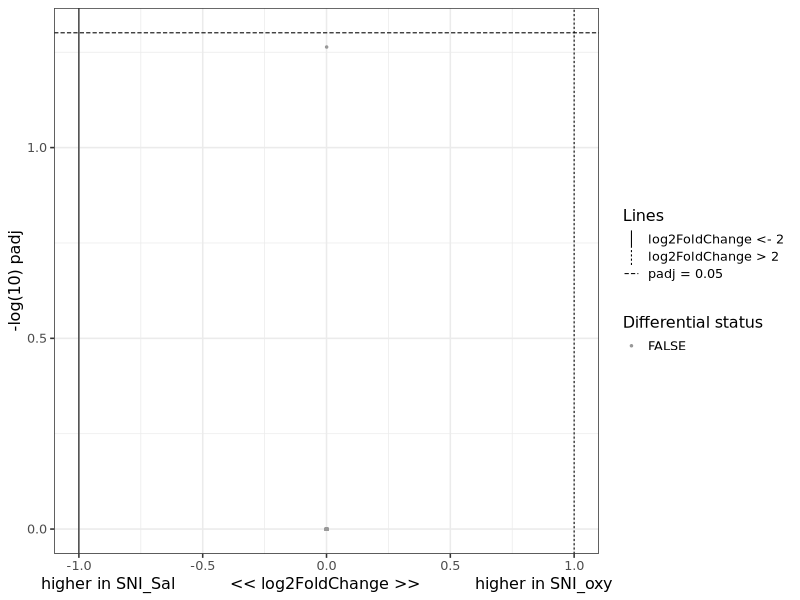

In [1]:
from PIL import Image

# Open the image
img = Image.open("/home/chrissi/BioPrak/computational-workflows-2025/notebooks/day_03/DEG_output_excluded/plots/differential/condition_control_treated/png/volcano.png")

# Show it
img.show()

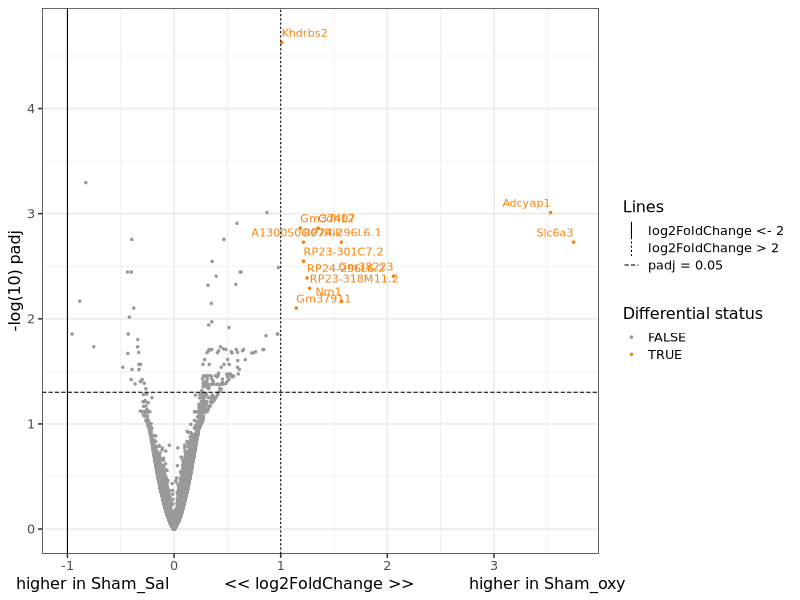

In [2]:
img = Image.open("/home/chrissi/BioPrak/computational-workflows-2025/notebooks/day_03/DEG_output_excluded/plots/differential/condition_control_treated_test/png/volcano.png")
img.show()